In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import os
from pathlib import Path

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
### 데이터 파일을 불러옵니다 ###
import numpy as np
import pandas as pd
data = pd.read_csv('chinaHR1_원자재Shaex포함3days.csv', index_col=0)

In [3]:
df = (data - data.min()) / (data.max() - data.min())

In [4]:
### 데이터를 넘파이(numpy) 파일로 변환하고 Shape을 확인합니다 ###
HR=df.values
print(HR.shape)

(912, 13)


In [5]:
### 2차원 데이터를 시간에 따라 스퀀스(연속)하게 투입하기 위해 3차원 넘파이로 만드는 함수입니다 ###
### 시계열 자료의 shape은 (sample, timesteps, features)의 3차원 구조를 띠어야 합니다 ###
#11까지 참조하여 12번째 예측

def split_xy(dataset, time_steps, y_column):
    x, y=list(), list()
    for i in range(len(dataset)):
        x_end_number=i+time_steps
        y_end_number=x_end_number+y_column
        if y_end_number>len(dataset):
            break
        tmp_x=dataset[i:x_end_number, :]
        tmp_y=dataset[x_end_number:y_end_number, 12]
        x.append(tmp_x)
        y.append(tmp_y)
    return np.array(x), np.array(y)

In [6]:
### timesteps와 예측하려는 시점을 설정한 후, 위의 시계열 분석을 위한 3차원 데이터 자르기 함수를 적용합니다 ###
### timestep를 60, y_column을 30으로 하면 이전 60일 데이터로 향후 30일을 예측하도록 3차원 넘파이 데이터가 구성됩니다 ###
time_steps=120
y_column=30
X, Y=split_xy(HR, time_steps, y_column)
print("X.shape : ", X.shape)
print("Y.shape : ", Y.shape)

X.shape :  (763, 120, 13)
Y.shape :  (763, 30)


In [7]:
X_train, y_train = X[:700, : ], Y[:700, : ]
X_test, y_test = X[700:, : ], Y[700:, : ]

In [8]:
print("X_train.shape : ", X_train.shape)
print("y_train.shape : ", y_train.shape)
print("X_test.shape : ", X_test.shape)
print("y_test.shape : ", y_test.shape)

X_train.shape :  (700, 120, 13)
y_train.shape :  (700, 30)
X_test.shape :  (63, 120, 13)
y_test.shape :  (63, 30)


# Model2: LSTM + CNN Model

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [9]:
xx=np.expand_dims(X[:, :, -1], axis=2)
y = np.expand_dims(Y, axis=2)
x = X
series=np.concatenate((xx, y), axis=1)
print("x.shape : ", x.shape)
print("y.shape : ", y.shape)
print("series.shape : ", series.shape)

x.shape :  (763, 120, 13)
y.shape :  (763, 30, 1)
series.shape :  (763, 150, 1)


In [10]:
Y = np.empty((len(X), time_steps, y_column))
for step_ahead in range(1, y_column + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + time_steps, 0]
Y_train = Y[:600]
Y_valid = Y[600:700]
Y_test = Y[700:]

In [11]:
X_train, y_train = X[:600, : ], Y[:600, : ]
X_valid, y_valid = X[600:700, : ] , Y[600:700, : ]
X_test, y_test = X[700:, : ], Y[700:, : ]

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model_1DCNN = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=30, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 13]),
    
#0~12까지의 13개 데이터를 참조
    
    tf.keras.layers.GRU(20, return_sequences=True),
    tf.keras.layers.GRU(20, return_sequences=True),
    tf.keras.layers.GRU(20, return_sequences=True),
    tf.keras.layers.GRU(20, return_sequences=True),
    tf.keras.layers.GRU(20, return_sequences=True),
    tf.keras.layers.GRU(20, return_sequences=True),
    tf.keras.layers.GRU(20, return_sequences=True),
    tf.keras.layers.GRU(20, return_sequences=True),
    tf.keras.layers.GRU(20, return_sequences=True),
    
    tf.keras.layers.TimeDistributed(keras.layers.Dense(y_column))
])

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5)

model_1DCNN.compile(loss="mse", optimizer="adam", metrics='accuracy')
history = model_1DCNN.fit(X_train, y_train[:, 3::2], epochs=300,
                          validation_data=(X_valid, y_valid[:, 3::2]), callbacks=[early_stopping])

Epoch 1/300
19/19 [==============================] - 3s 164ms/step - loss: 0.2688 - accuracy: 0.0215 - val_loss: 0.3019 - val_accuracy: 0.0232
Epoch 2/300
19/19 [==============================] - 2s 90ms/step - loss: 0.1358 - accuracy: 0.0202 - val_loss: 0.1317 - val_accuracy: 0.0198
Epoch 3/300
19/19 [==============================] - 2s 89ms/step - loss: 0.0858 - accuracy: 0.0279 - val_loss: 0.0779 - val_accuracy: 0.0605
Epoch 4/300
19/19 [==============================] - 2s 91ms/step - loss: 0.0469 - accuracy: 0.0328 - val_loss: 0.0417 - val_accuracy: 0.0322
Epoch 5/300
19/19 [==============================] - 2s 89ms/step - loss: 0.0238 - accuracy: 0.0348 - val_loss: 0.0308 - val_accuracy: 0.0153
Epoch 6/300
19/19 [==============================] - 2s 89ms/step - loss: 0.0183 - accuracy: 0.0521 - val_loss: 0.0291 - val_accuracy: 0.0319
Epoch 7/300
19/19 [==============================] - 2s 89ms/step - loss: 0.0152 - accuracy: 0.0608 - val_loss: 0.0282 - val_accuracy: 0.0322
Epoch

In [13]:
model_1DCNN.evaluate(X_test)

2/2 [==============================] - 0s 663us/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

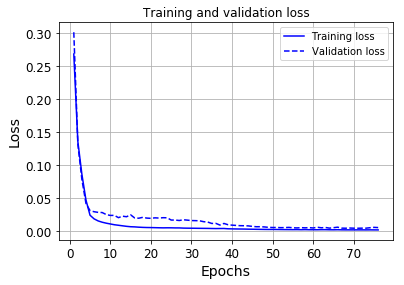

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss')
plt.grid(True)
plt.legend(fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [16]:

All_predict_x=X[:,:]
All_predict_3D=np.reshape(All_predict_x, (1,time_steps,len(HR[0,:])))
All_predict = model_1DCNN.predict(All_predict_3D)
All_predict_value=np.reshape(All_predict[0, 0, : ], (1,y_column))

ValueError: cannot reshape array of size 1190280 into shape (1,120,13)

In [29]:
predict_values=model_1DCNN.predict(X, Y[:, 3::2])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [21]:
predict_values=model_1DCNN.fit(X, Y[:, 3::2])

24/24 [==============================] - 2s 86ms/step - loss: 0.0030 - accuracy: 0.1690


In [25]:
predict_values=model_1DCNN.predict(X, Y[:, 3::2])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [30]:
### 가장 마지막 시계열을 timestep만큼 가져옵니다 ###
### 예측을 위해서는 3차원 numpy이어야 하므로 차원 1을 더합니다 ###
### 학습된 모델로 예측하여 y_column만큼 예측치를 forecase에 저장합니다 ###
fore2_x=HR[-time_steps:, ]
fore2_3D=np.reshape(fore2_x, (1,time_steps,len(HR[0,:])))
forecast2 = model_1DCNN.predict(fore2_3D)
fore_value2=np.reshape(forecast2[0, 0, : ], (1,y_column))

In [31]:
forecast2

array([[[0.5162092 , 0.51269394, 0.5231807 , ..., 0.54325837,
         0.57639563, 0.5423865 ],
        [0.4610637 , 0.47671258, 0.48819032, ..., 0.38345614,
         0.38086998, 0.39532974],
        [0.48346698, 0.49597   , 0.4862409 , ..., 0.39680398,
         0.40606296, 0.41936585],
        ...,
        [0.5916446 , 0.6035117 , 0.59988385, ..., 0.7500239 ,
         0.75468946, 0.76031697],
        [0.598436  , 0.6106796 , 0.607434  , ..., 0.7615071 ,
         0.76603484, 0.77243984],
        [0.6100422 , 0.6225748 , 0.61832535, ..., 0.7824172 ,
         0.790257  , 0.7961277 ]]], dtype=float32)

In [32]:
#12개로 예측
import pandas
real_scaled2=pd.DataFrame(HR[:, 12])
real_scaled2.columns=['ChinadomesticHR']
real_scaled2['group']=1

forecast_scaled2=pd.DataFrame(fore_value2[0,:])
forecast_scaled2.columns=['ChinadomesticHR']
forecast_scaled2['group']=2

Trend2=pd.concat([real_scaled2, forecast_scaled2], axis=0, ignore_index=True)
Trend2['date']=pd.date_range(start="2013-1-1", periods=len(HR)+y_column)

Trend2['orginal']=Trend2['ChinadomesticHR']*(data['ChinadomesticHR'].max()-data['ChinadomesticHR'].min())+data['ChinadomesticHR'].min()

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'price')

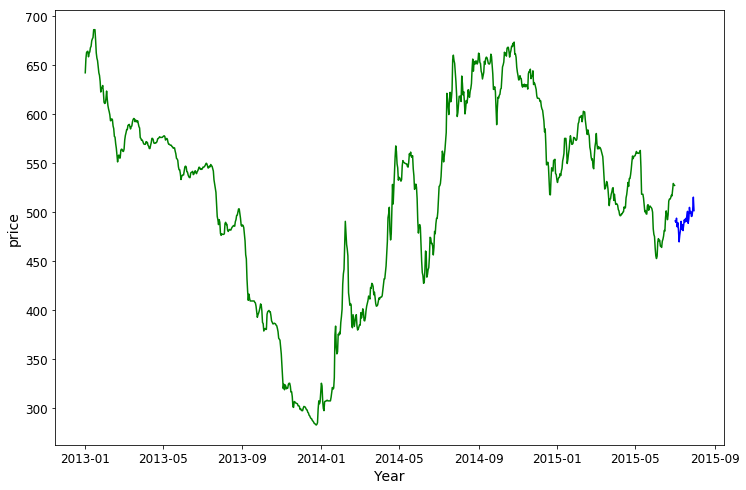

In [33]:
Real2=Trend2[(Trend2['group']==1)]
Fore2=Trend2[(Trend2['group']==2)]

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(Real2['date'], Real2['orginal'], 'g-', label='Training loss')
plt.plot(Fore2['date'], Fore2['orginal'], 'b-', label='Training loss')
plt.xlabel('Year')
plt.ylabel('price')

Text(0, 0.5, 'price')

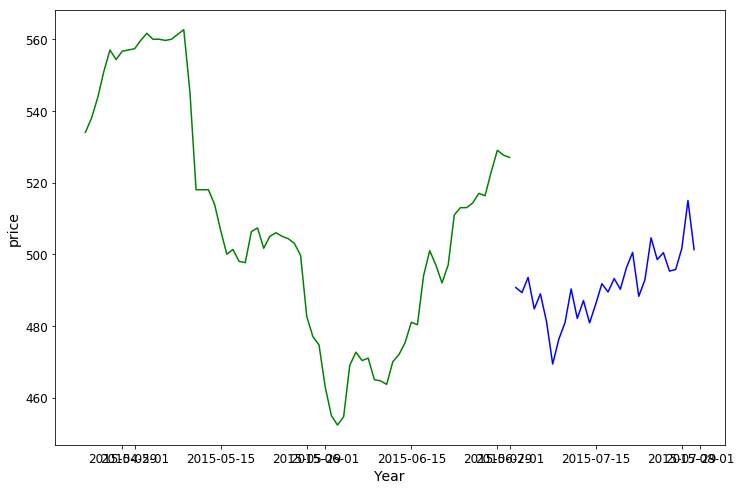

In [34]:
Trend2_100=Trend2.tail(100)

Real2_100=Trend2_100[(Trend2_100['group']==1)]
Fore2_100=Trend2_100[(Trend2_100['group']==2)]

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(Real2_100['date'], Real2_100['orginal'], 'g-', label='Training loss')
plt.plot(Fore2_100['date'], Fore2_100['orginal'], 'b-', label='Training loss')
plt.xlabel('Year')
plt.ylabel('price')

In [35]:
Trend2.tail(40)

ChinadomesticHR  group       date     orginal
902         0.566474      1 2015-06-22  511.000000
903         0.571429      1 2015-06-23  513.000000
904         0.571429      1 2015-06-24  513.000000
905         0.574732      1 2015-06-25  514.333333
906         0.581338      1 2015-06-26  517.000000
907         0.579686      1 2015-06-27  516.333333
908         0.596201      1 2015-06-28  523.000000
909         0.611065      1 2015-06-29  529.000000
910         0.607762      1 2015-06-30  527.666667
911         0.606111      1 2015-07-01  527.000000
912         0.516209      2 2015-07-02  490.709774
913         0.512694      2 2015-07-03  489.290788
914         0.523181      2 2015-07-04  493.523952
915         0.501433      2 2015-07-05  484.745271
916         0.511843      2 2015-07-06  488.947205
917         0.492558      2 2015-07-07  481.162532
918         0.463282      2 2015-07-08  469.344902
919         0.480522      2 2015-07-09  476.304206
920         0.491907      2 2015-07-10  480.899841
921         0.515215      2 2015-07-11  490.308543
922         0.494846      2 2015-07-12  482.086235
923         0.507206      2 2015-07-13  487.075690
924         0.491786      2 2015-07-14  480.850950
925         0.504770      2 2015-07-15  486.092005
926         0.518871      2 2015-07-16  491.784144
927         0.513104      2 2015-07-17  489.456131
928         0.522447      2 2015-07-18  493.227648
929         0.515018      2 2015-07-19  490.228831
930         0.529975      2 2015-07-20  496.266381
931         0.540459      2 2015-07-21  500.498559
932         0.510159      2 2015-07-22  488.267426
933         0.521545      2 2015-07-23  492.863734
934         0.550537      2 2015-07-24  504.566789
935         0.535565      2 2015-07-25  498.523175
936         0.540313      2 2015-07-26  500.439828
937         0.527542      2 2015-07-27  495.284452
938         0.528699      2 2015-07-28  495.751440
939         0.543258      2 2015-07-29  501.628628
940         0.576396      2 2015-07-30  515.005036
941         0.542386      2 2015-07-31  501.276673